Решение:

- Колонки сюжета и описание объединили в одну. (На один фильм получилось два объекта в обучающей выборке)
- Длинные тексты разбили на чанки по 150 слов. (На один фильм получилось ещё больше объектов в обучающей выборке)
- В качестве ответа брали средний результат по всем разбивкам для одного фильма
- C помощью spacy и модели "ru_core_news_lg" в тексте заменили различные города, страны и тд. на слово "локация", а имена персонажей на "герой". (Задача NER)
- В текстах заменили название фильмов на "фильм".
- Финальная модель - ai-forever/ruBert-base с max_length = 256, batch_size = 8, num_epochs = 3, lr=0.00001

Что ещё пробовали, но это не улучшило результат:

- Аугментации. Переводили текст на английский и обратно, чтобы увеличить количество объектов для обучения. Модели Helsinki-NLP/opus-mt-ru-en и Helsinki-NLP/opus-mt-en-ru.
- Разное количество слов в чанках 50-300.
- Разный max_length от 128 до 512.
- Разные модели:
  - cointegrated/rubert-tiny2
  - ai-forever/ruRoberta-large
  - ai-forever/ruBert-large
  - DeepPavlov/rubert-base-cased
- Персональный threshold для каждого класса, чтобы распределение классов на тесте совпало с трейном.
- Пробовали применять модели суммаризации текстов, чтобы текст влезал в лимит 512 токенов.
- Разбивать текст не на чанки, а применить метод sliding window (двигаться по тексту окном и классифицировать) и также усреднять.

Общие выводы:

- Сильный дисбаланс классов в задаче
- Мало объектов для тренировки (500) для таких больших моделей как BERTы.
- Метрика F1-macro при дисбалансе классов сильно меняется при небольшом изменении пайплайна. Существуют классы типа "мюзикл", доля которых очень мала в обучающей выборке. При этом в метрике F1-macro этот класс оценивается наравне со всеми. В совокупности с малым размером публичного теста (100) скор прыгал от 0.45 до 0.62 при смене threshold на 0.1.
- Сами фильмы очень тяжело классифицировать даже человеку)). Например, по сюжету иногда невозможно понять, что это мультфильм.

Что ещё можно было попробовать:

- Ещё больший подбор гиперпараметров?
- Lr scheduler, чтобы стабилизировать обучение?
- Аугментации с помощью синонимов?
- Ещё сильнее почистить данные: классические лемматизация, стемминг, удаление стоп-слов?? хотя для BERT моделей это обычно не нужно.
- Ансамбли моделей? Взять BERTы для русского языка, а также перевести тексты на английский и взять BERTы для английского, и всё объединить с весами в зависимости от валидации?
- Применить longformer модели для классификации длинных текстов?

In [ ]:
!pip install gdown transformers datasets pandas numpy tqdm torch torchvision spacy wandb scikit-learn nltk pandarallel -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 79.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 21.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have

In [ ]:
!gdown 1JBldDLK2wrgfD1CheAv4FKsLBf71Avis
!gdown 1yjQNhMqiZnK81Xo1Nci0ubi2VXYsda5r
!gdown 13c4PfMp-f4EKKdpSV6twqnYu7J-psYTm
!gdown 1tJWCpJLl_G3neg3eFvCGA1I5SgZDzr3w

Downloading...
From: https://drive.google.com/uc?id=1JBldDLK2wrgfD1CheAv4FKsLBf71Avis
To: /content/train.csv
100% 3.67M/3.67M [00:00<00:00, 222MB/s]
Downloading...
From: https://drive.google.com/uc?id=1yjQNhMqiZnK81Xo1Nci0ubi2VXYsda5r
To: /content/sample_submission_seed_0.csv
100% 19.3k/19.3k [00:00<00:00, 44.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=13c4PfMp-f4EKKdpSV6twqnYu7J-psYTm
To: /content/public_test.csv
100% 923k/923k [00:00<00:00, 84.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1tJWCpJLl_G3neg3eFvCGA1I5SgZDzr3w
To: /content/private_test.csv
100% 811k/811k [00:00<00:00, 48.1MB/s]


In [ ]:
!python -m spacy download ru_core_news_lg -q
!python -m nltk.downloader popular -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.4/513.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 51.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
/usr/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))


In [ ]:
# !wandb login

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import os
import random
import re

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import spacy
import torch
import transformers
import wandb
from datasets import Dataset, load_dataset
from nltk.tokenize import sent_tokenize, word_tokenize
from pandarallel import pandarallel
from sklearn import metrics
from sklearn.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.preprocessing import MultiLabelBinarizer
from torch import cuda
from torch.optim import Adam
from torch.utils.data import DataLoader
from tqdm import tqdm
from tqdm.notebook import tqdm
from transformers import (
    AutoTokenizer,
    BertConfig,
    BertForSequenceClassification,
    BertModel,
    BertTokenizer,
    DataCollatorWithPadding,
)

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)
device = "cuda" if cuda.is_available() else "cpu"

In [ ]:
def calculate_f1_scores_multilabel(y_true, y_pred, num_labels, threshold):
    return [f1_score(y_true[:, i], y_pred[:, i] >= threshold) for i in range(num_labels)]


def calculate_f1_score_multilabel(y_true, y_pred, threshold, average):
    return f1_score(y_true, y_pred >= threshold, average=average)


def f1_df_for_each_threshold(y_true, y_pred, num_labels):
    scores = {}
    for threshold in [x / 10 for x in range(11)]:
        scores[threshold] = calculate_f1_scores_multilabel(
            y_true, y_pred, num_labels, threshold
        )
        scores[threshold].append(
            calculate_f1_score_multilabel(y_true, y_pred, threshold, "macro")
        )
    return scores

In [ ]:
nlp = spacy.load("ru_core_news_lg")
pandarallel.initialize(progress_bar=True)


def split_text_chunks(text, max_words=150, min_words=25):
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_word_count = 0

    for sentence in sentences:
        sentence_word_count = len(sentence.split())

        if current_word_count + sentence_word_count > max_words:
            chunks.append(" ".join(current_chunk))
            current_chunk = [sentence]
            current_word_count = sentence_word_count
        else:
            current_chunk.append(sentence)
            current_word_count += sentence_word_count

    if current_chunk and current_word_count >= min_words:
        chunks.append(" ".join(current_chunk))

    return chunks if chunks else [text]


def get_chunked_dataframe(df):
    df = df.copy()
    chunked_rows = []

    for _, row in df.iterrows():
        if pd.notna(row["text"]):
            text_chunks = split_text_chunks(row["text"])
            for chunk in text_chunks:
                chunked_rows.append([row["movie"], chunk, row["genres"]])
    chunked = pd.DataFrame(chunked_rows, columns=["movie", "text", "genres"])
    chunked["text"].apply(lambda x: len(x.split())).hist(bins=20)

    chunked["text"] = chunked["text"].apply(clear_text)
    return chunked


def clear_text(text):
    text = text.replace("\n", " ")
    text = text.replace("\t", " ")
    text = text.replace("\xa0", " ")
    return " ".join(text.split())


def replace_entities(text, nlp):
    doc = nlp(text)
    modified_text = text
    for ent in doc.ents:
        if ent.label_ == "PER":
            modified_text = modified_text.replace(ent.text, "герой")
        elif ent.label_ == "LOC":
            modified_text = modified_text.replace(ent.text, "локация")
    return modified_text


def remove_film_name_from_text(text, film_title):

    film_title_clean = re.sub(r"\(.*?\)", "", film_title).strip()
    text = text.replace(film_title, "фильм")
    text = text.replace(film_title_clean, "фильм")
    return text


def preprocess_train(df: pd.DataFrame):
    df = df.copy()

    df = df.rename(
        {
            "Фильм": "movie",
            "Сюжет": "plot",
            "Жанры": "genres",
            "Описание": "description",
        },
        axis=1,
    )
    print(df.isnull().any())
    df_description = (
        df[["movie", "description", "genres"]]
        .rename(columns={"description": "text"})
        .dropna(subset=["text"])
    )
    df_plot = (
        df[["movie", "plot", "genres"]]
        .rename(columns={"plot": "text"})
        .dropna(subset=["text"])
    )
    df_doubled = pd.concat([df_description, df_plot], ignore_index=True)
    df_doubled["text"] = df_doubled["text"].apply(clear_text)
    df_doubled["text"] = df_doubled["text"].parallel_apply(
        lambda x: replace_entities(x, nlp)
    )
    df_doubled["text"] = df_doubled["text"].apply(clear_text)
    df_doubled["text"] = df_doubled.apply(
        lambda x: remove_film_name_from_text(x["text"], x["movie"]), axis=1
    )
    df_doubled["text"] = df_doubled["text"].apply(clear_text)
    df_doubled["text"].apply(lambda x: len(x.split())).hist(bins=20)
    plt.show()
    return df_doubled

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [ ]:
df_train = pd.read_csv("/content/train.csv")

movie          False
description    False
plot            True
genres         False
dtype: bool


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


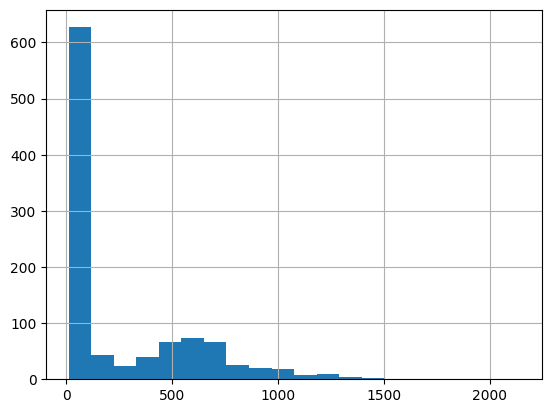

,movie,text,genres
0,Дивергент (2014),"Действие фильма «фильм» происходит в мире, пер...","фантастика, детектив, боевик, мелодрама"
1,Кунг-фу Панда 4 (2024),Однажды ночью на вершине горы возле каменоломн...,"мультфильм, фэнтези, боевик, комедия, приключения"
2,2046 (2004),герой возвращается в локация после нескольких ...,"фантастика, драма, мелодрама"
3,Полицейский из Беверли-Хиллз: Аксель Фоули (2024),"герой вернулся в локация после того, как жизнь...","боевик, комедия, криминал, детектив"
4,"Знакомьтесь, Джо Блэк (1998)","История об герой, который решает взять отпуск ...","мелодрама, фэнтези, драма"
...,...,...,...
1027,2+1 (2016),"геройгерой), бегун, любитель вечеринок и бабни...","комедия, драма"
1028,Апокалипсис (2006),1517 год. Полуостров локация. Группа охотников...,"боевик, триллер, драма, приключения"
1029,Лёд 3 (2024),Фильм начинается с истории взросления дочери г...,"мюзикл, мелодрама"
1030,Не говори никому (2024),Пара вместе с дочерью получают приглашение от ...,"триллер, драма"


In [ ]:
df_train = preprocess_train(df_train)
df_train

,movie,text,genres
0,Дивергент (2014),"Действие фильма «фильм» происходит в мире, пер...","фантастика, детектив, боевик, мелодрама"
1,Кунг-фу Панда 4 (2024),Однажды ночью на вершине горы возле каменоломн...,"мультфильм, фэнтези, боевик, комедия, приключения"
2,2046 (2004),герой возвращается в локация после нескольких ...,"фантастика, драма, мелодрама"
3,Полицейский из Беверли-Хиллз: Аксель Фоули (2024),"герой вернулся в локация после того, как жизнь...","боевик, комедия, криминал, детектив"
4,"Знакомьтесь, Джо Блэк (1998)","История об герой, который решает взять отпуск ...","мелодрама, фэнтези, драма"
...,...,...,...
2524,Принцесса Мононоке (1997),"Когда-то эту землю укрывал лес, где с незапамя...","мультфильм, фэнтези, боевик, драма, приключения"
2525,Принцесса Мононоке (1997),Сначала монах помогает герой выйти из затрудни...,"мультфильм, фэнтези, боевик, драма, приключения"
2526,Принцесса Мононоке (1997),"В сражении гибнут люди, быки, летят в пропасть...","мультфильм, фэнтези, боевик, драма, приключения"
2527,Принцесса Мононоке (1997),Тем не менее герой так и не избавляется от про...,"мультфильм, фэнтези, боевик, драма, приключения"


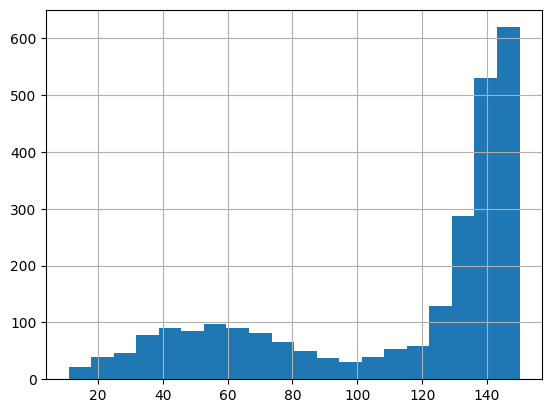

In [ ]:
df_train = get_chunked_dataframe(df_train)
df_train

In [ ]:
df_train["genres"] = df_train["genres"].apply(lambda x: x.split(", "))
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df_train["genres"])
df_train["target"] = y.tolist()
df_train = df_train.drop("genres", axis=1)
df_train

,movie,text,target
0,Дивергент (2014),"Действие фильма «фильм» происходит в мире, пер...","[1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
1,Кунг-фу Панда 4 (2024),Однажды ночью на вершине горы возле каменоломн...,"[1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1]"
2,2046 (2004),герой возвращается в локация после нескольких ...,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0]"
3,Полицейский из Беверли-Хиллз: Аксель Фоули (2024),"герой вернулся в локация после того, как жизнь...","[1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
4,"Знакомьтесь, Джо Блэк (1998)","История об герой, который решает взять отпуск ...","[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1]"
...,...,...,...
2524,Принцесса Мононоке (1997),"Когда-то эту землю укрывал лес, где с незапамя...","[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]"
2525,Принцесса Мононоке (1997),Сначала монах помогает герой выйти из затрудни...,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]"
2526,Принцесса Мононоке (1997),"В сражении гибнут люди, быки, летят в пропасть...","[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]"
2527,Принцесса Мононоке (1997),Тем не менее герой так и не избавляется от про...,"[1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1]"


In [ ]:
max_length = 256
num_labels = len(mlb.classes_)
label2id = dict(zip(mlb.classes_, range(num_labels)))
id2label = dict(zip(range(num_labels), mlb.classes_))
model = "ai-forever/ruBert-base"
problem_type = "multi_label_classification"
batch_size = 8
pin_memory = False
drop_last = False
num_workers = 4
shuffle = True
num_epochs = 3


os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["TRANSFORMERS_NO_ADVISORY_WARNINGS"] = "true"

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model)

model = BertForSequenceClassification.from_pretrained(
    model,
    num_labels=num_labels,
    problem_type=problem_type,
    label2id=label2id,
    id2label=id2label,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/590 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/1.78M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/716M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ai-forever/ruBert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
dataset_train = Dataset.from_pandas(df_train)
dataset_train = dataset_train.map(
    lambda x: tokenizer(x["text"], truncation=True, max_length=max_length),
    batched=True,
)
dataset_train = dataset_train.map(
    lambda x: {"label": [float(y) for y in x["target"]]},
    batched=False,
    remove_columns=["text", "target"],
)

Map:   0%|          | 0/2529 [00:00<?, ? examples/s]

Map:   0%|          | 0/2529 [00:00<?, ? examples/s]

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer)
train_wo_movie = dataset_train.remove_columns(["movie"])

train_dataloader = DataLoader(
    train_wo_movie,
    batch_size=batch_size,
    shuffle=shuffle,
    num_workers=num_workers,
    collate_fn=data_collator,
    pin_memory=pin_memory,
    drop_last=drop_last,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def predict(model, dataloader):
    with torch.inference_mode():
        y_true = []
        y_pred = []
        val_loss = 0

        for batch in tqdm(dataloader):
            batch = batch.to(model.device)
            output = model(**batch)
            loss = output.loss

            val_loss += loss.item() * batch["input_ids"].size(0)
            y_true.append(batch.labels.cpu())
            y_pred.append(output.logits.cpu())

        val_loss = val_loss / len(dataloader.dataset)

    return (
        torch.cat(y_true).numpy(),
        torch.sigmoid(torch.cat(y_pred)).numpy(),
        val_loss,
    )


def train_epoch(model, train_dataloader, optimizer):
    y_true = []
    y_pred = []
    train_loss = 0

    for batch in tqdm(train_dataloader):
        optimizer.zero_grad()
        batch = batch.to(model.device)
        output = model(**batch)
        loss = output.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * batch["input_ids"].size(0)
        y_true.append(batch.labels.detach().cpu())
        y_pred.append(output.logits.detach().cpu())

    train_loss = train_loss / len(train_dataloader.dataset)
    return (
        torch.cat(y_true).numpy(),
        torch.sigmoid(torch.cat(y_pred)).numpy(),
        train_loss,
    )


def eval(model, val_dataloader, labels, dataset):
    model.eval()
    val_y_true, val_y_pred, val_loss = predict(model, val_dataloader)

    df_eval = dataset.to_pandas()
    df_eval = df_eval.drop(["input_ids", "attention_mask", "token_type_ids"], axis=1)

    df_eval["eval"] = val_y_pred.tolist()
    gb = (
        df_eval.groupby("movie")
        .agg({"eval": lambda x: [sum(i) / len(i) for i in zip(*x)], "label": "first"})
        .reset_index()
    )

    report_dict = f1_df_for_each_threshold(
        np.array(gb["label"].to_list()), np.array(gb["eval"].to_list()), num_labels
    )

    df = pd.DataFrame(report_dict)
    df = df.round(2).T
    df.columns = [*labels, "macro"]
    return df, val_y_true, val_y_pred, val_loss

In [ ]:
def train(model, train_dataloader, optimizer, epochs, val_dataloader, labels, dataset):
    tq = tqdm(range(epochs))

    for epoch in tq:

        model.train()
        train_y_true, train_y_pred, train_loss = train_epoch(
            model, train_dataloader, optimizer
        )

        model.eval()

        df, val_y_true, val_y_pred, val_loss = eval(
            model, val_dataloader, labels, dataset
        )

        # wandb.log(
        #     {
        #         "train_loss": train_loss,
        #         "val_loss": val_loss,
        #         "f10.5": df["macro"].loc[0.5],
        #         "f10.3": df["macro"].loc[0.3],
        #         "f10.4": df["macro"].loc[0.4],
        #     }
        # )

        tq.set_description(f"train_loss: {train_loss:.4f}, val_loss: {val_loss:.4f}")

    df, val_y_true, val_y_pred, val_loss = eval(model, val_dataloader, labels, dataset)

    display(df)

    return val_y_true, val_y_pred

In [ ]:
torch.cuda.empty_cache()
model.cuda()

optimizer = Adam(model.parameters(), lr=0.00001)
# wandb.init("mtc-nlp")

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: seara. Use `wandb login --relogin` to force relogin


In [ ]:
val_y_true, val_y_pred = train(
    model=model,
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=num_epochs,
    val_dataloader=train_dataloader,  # в данном ноутбуке обучаюсь на всех данных без валидации
    labels=id2label.values(),
    dataset=dataset_train,
)
# wandb.finish()

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/317 [00:00<?, ?it/s]

  0%|          | 0/317 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


,боевик,детектив,драма,история,комедия,криминал,мелодрама,мультфильм,мюзикл,приключения,триллер,ужасы,фантастика,фэнтези,macro
0.0,0.49,0.24,0.67,0.20,0.49,0.34,0.26,0.16,0.04,0.36,0.42,0.19,0.35,0.27,0.32
0.1,0.50,0.26,0.66,0.17,0.49,0.35,0.24,0.18,0.00,0.37,0.42,0.18,0.34,0.29,0.32
0.2,0.49,0.26,0.66,0.12,0.47,0.34,0.16,0.18,0.00,0.37,0.41,0.15,0.33,0.29,0.30
0.3,0.46,0.17,0.64,0.06,0.41,0.24,0.10,0.00,0.00,0.31,0.31,0.08,0.25,0.23,0.23
0.4,0.35,0.06,0.58,0.03,0.30,0.08,0.04,0.00,0.00,0.20,0.19,0.03,0.18,0.13,0.16
0.5,0.23,0.02,0.48,0.00,0.19,0.01,0.04,0.00,0.00,0.12,0.08,0.03,0.11,0.07,0.10
0.6,0.11,0.00,0.27,0.00,0.09,0.02,0.00,0.00,0.00,0.13,0.05,0.03,0.04,0.04,0.05
0.7,0.05,0.00,0.15,0.00,0.04,0.02,0.00,0.00,0.00,0.08,0.04,0.00,0.01,0.02,0.03
0.8,0.03,0.00,0.06,0.00,0.01,0.00,0.00,0.00,0.00,0.08,0.00,0.00,0.01,0.02,0.02
0.9,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00


f10.3,▁██
f10.4,▁▅█
f10.5,▁██
train_loss,█▄▁
val_loss,█▄▁
f10.3,0.24
f10.4,0.17
f10.5,0.1
train_loss,0.29812
val_loss,0.24889


In [ ]:
model.cpu()
model.save_pretrained("models/rubert-base", safe_serialization=False)
tokenizer.save_pretrained("models/rubert-base")
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(120138, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

movie          False
description    False
plot            True
genres         False
dtype: bool


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


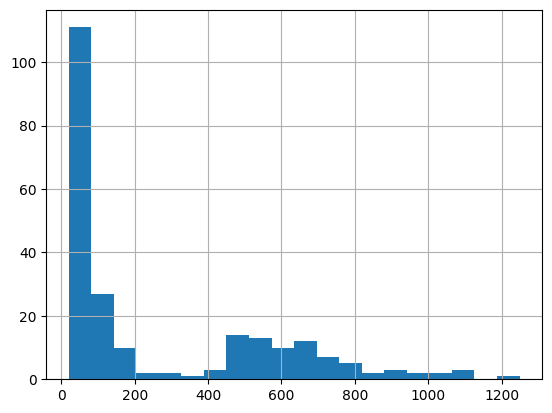

Map:   0%|          | 0/550 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/69 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


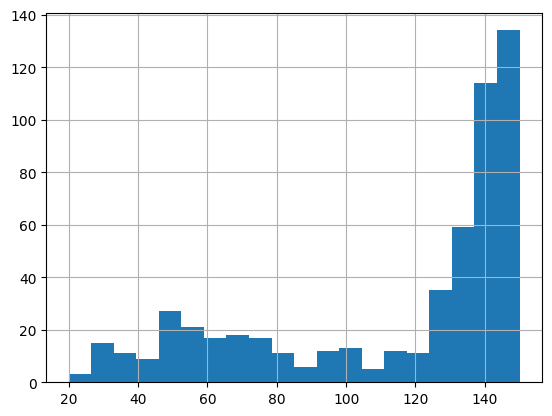

In [ ]:
submission = pd.read_csv("/content/private_test.csv")
submission["Жанры"] = "empty"
submission = preprocess_train(submission)
submission = get_chunked_dataframe(submission)

dataset = Dataset.from_pandas(submission[["text"]])
dataset = dataset.map(
    lambda x: tokenizer(x["text"], truncation=True, max_length=max_length),
    batched=True,
    remove_columns=["text"],
)
test_dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    collate_fn=data_collator,
    pin_memory=pin_memory,
    drop_last=drop_last,
)


def test(model, dataloader):
    with torch.inference_mode():
        y_pred = []

        for batch in tqdm(dataloader):
            batch = batch.to(model.device)
            output = model(**batch)

            y_pred.append(output.logits.cpu())

    return torch.sigmoid(torch.cat(y_pred)).numpy()


prediction = test(model, test_dataloader)

submission["genres"] = prediction.tolist()

submission = (
    submission.groupby("movie")["genres"]
    .agg(lambda x: [sum(i) / len(i) for i in zip(*x)])
    .reset_index()
)

submission.columns = ["Фильм", "Жанры"]

threshold = 0.3
predicted_labels = []
for pred_ in submission["Жанры"].to_list():
    pred = (np.array(pred_) >= threshold).astype(int)
    labels = [id2label[idx] for idx, value in enumerate(pred) if value == 1]
    if not labels:
        labels = [id2label[np.argmax(pred)]]
    predicted_labels.append(labels)

submission["Жанры"] = predicted_labels
submission["Жанры"] = submission["Жанры"].apply(lambda x: ", ".join(x))
submission.set_index("Фильм").loc[
    pd.read_csv("/content/private_test.csv")["Фильм"]
].to_csv("rubert-base-submission-private.csv")

In [ ]:
!zip -r models.zip /content/models

  adding: content/models/ (stored 0%)
  adding: content/models/rubert-base/ (stored 0%)
  adding: content/models/rubert-base/tokenizer_config.json (deflated 75%)
  adding: content/models/rubert-base/pytorch_model.bin (deflated 7%)
  adding: content/models/rubert-base/special_tokens_map.json (deflated 42%)
  adding: content/models/rubert-base/tokenizer.json (deflated 73%)
  adding: content/models/rubert-base/config.json (deflated 71%)
  adding: content/models/rubert-base/vocab.txt (deflated 66%)
